In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats


In [2]:
root_path = '/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset'

In [3]:
df = pd.read_csv(root_path+'/train/machine-1-1.txt')
with open(root_path+'/interpretation_label/machine-1-1.txt', 'r') as file:
    anomaly_events = file.readlines()

In [4]:
# Renaming the columns for clarity
column_names = [f"Dimension {i+1}" for i in range(38)]
df.columns = column_names

# Re-display the first few rows with updated column names
df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 29,Dimension 30,Dimension 31,Dimension 32,Dimension 33,Dimension 34,Dimension 35,Dimension 36,Dimension 37,Dimension 38
0,0.043011,0.048729,0.033445,0.025552,0.0,0.915385,0.344633,0.0,0.019160,0.001722,...,0.0,0.004298,0.030041,0.028821,0.0,0.000045,0.035763,0.035833,0.0,0.0
1,0.043011,0.034958,0.032330,0.025552,0.0,0.915385,0.344633,0.0,0.020011,0.000122,...,0.0,0.004298,0.026248,0.021101,0.0,0.000045,0.033012,0.033082,0.0,0.0
2,0.032258,0.028602,0.030100,0.024390,0.0,0.912821,0.342750,0.0,0.021289,0.000000,...,0.0,0.004298,0.030169,0.025733,0.0,0.000022,0.035112,0.035182,0.0,0.0
3,0.032258,0.019068,0.026756,0.023229,0.0,0.912821,0.342750,0.0,0.018734,0.000000,...,0.0,0.004298,0.027240,0.022645,0.0,0.000034,0.033447,0.033517,0.0,0.0
4,0.043011,0.007415,0.021182,0.022067,0.0,0.917949,0.343691,0.0,0.019160,0.000000,...,0.0,0.004298,0.030217,0.022645,0.0,0.000034,0.034171,0.034241,0.0,0.0


In [5]:

# The anomaly information as interpreted from the TXT file
anomaly_info = """
15849-16368:1,9,10,12,13,14,15
16963-17517:1,2,3,4,6,7,9,10,11,12,13,14,15,16,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36
18071-18528:1,2,9,10,12,13,14,15
19367-20088:1,2,3,4,9,10,11,12,13,14,15,16,25,28
20786-21195:1,9,10,12,13,14,15
24679-24682:9,13,14,15
26114-26116:9,13,14,15
27554-27556:9,13,14,15
"""

# Parse the anomaly information
anomalies = []
for line in anomaly_info.strip().split('\n'):
    steps, dimensions = line.split(':')
    start_step, end_step = map(int, steps.split('-'))
    dimensions = list(map(int, dimensions.split(',')))
    for step in range(start_step, end_step + 1):
        anomalies.append({'step': step, 'dimensions': dimensions})

# Convert to DataFrame for easier manipulation
anomalies_df = pd.DataFrame(anomalies)

# Add a column to the original dataframe to label anomalies
df['Anomaly'] = 0  # Assume no anomaly initially
for index, row in anomalies_df.iterrows():
    df.loc[row['step'] - 1, 'Anomaly'] = 1  # -1 to adjust for 0-based indexing in the dataframe

# Verify by displaying rows where anomaly is labeled
df[df['Anomaly'] == 1].head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 30,Dimension 31,Dimension 32,Dimension 33,Dimension 34,Dimension 35,Dimension 36,Dimension 37,Dimension 38,Anomaly
15848,0.075269,0.062500,0.078038,0.075494,0.0,0.905128,0.310734,0.0,0.019728,0.000000,...,0.005731,0.062242,0.046320,0.000000,0.000034,0.065084,0.065079,0.0,0.0,1
15849,0.064516,0.088983,0.084727,0.077816,0.0,0.910256,0.310734,0.0,0.020011,0.000122,...,0.005731,0.060577,0.051981,0.000386,0.000045,0.066821,0.066889,0.0,0.0,1
15850,0.075269,0.169492,0.101449,0.083624,0.0,0.905128,0.308851,0.0,0.019302,0.000000,...,0.005731,0.061922,0.042717,0.000386,0.000011,0.064142,0.064210,0.0,0.0,1
15851,0.064516,0.076271,0.086957,0.078978,0.0,0.905128,0.307910,0.0,0.013767,0.000000,...,0.005731,0.060641,0.052496,0.000386,0.000034,0.066894,0.066889,0.0,0.0,1
15852,0.053763,0.072034,0.081382,0.077816,0.0,0.910256,0.308851,0.0,0.020721,0.000000,...,0.005731,0.052879,0.039115,0.000000,0.000022,0.060450,0.060518,0.0,0.0,1


In [6]:
df.columns

Index(['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
       'Dimension 5', 'Dimension 6', 'Dimension 7', 'Dimension 8',
       'Dimension 9', 'Dimension 10', 'Dimension 11', 'Dimension 12',
       'Dimension 13', 'Dimension 14', 'Dimension 15', 'Dimension 16',
       'Dimension 17', 'Dimension 18', 'Dimension 19', 'Dimension 20',
       'Dimension 21', 'Dimension 22', 'Dimension 23', 'Dimension 24',
       'Dimension 25', 'Dimension 26', 'Dimension 27', 'Dimension 28',
       'Dimension 29', 'Dimension 30', 'Dimension 31', 'Dimension 32',
       'Dimension 33', 'Dimension 34', 'Dimension 35', 'Dimension 36',
       'Dimension 37', 'Dimension 38', 'Anomaly'],
      dtype='object')

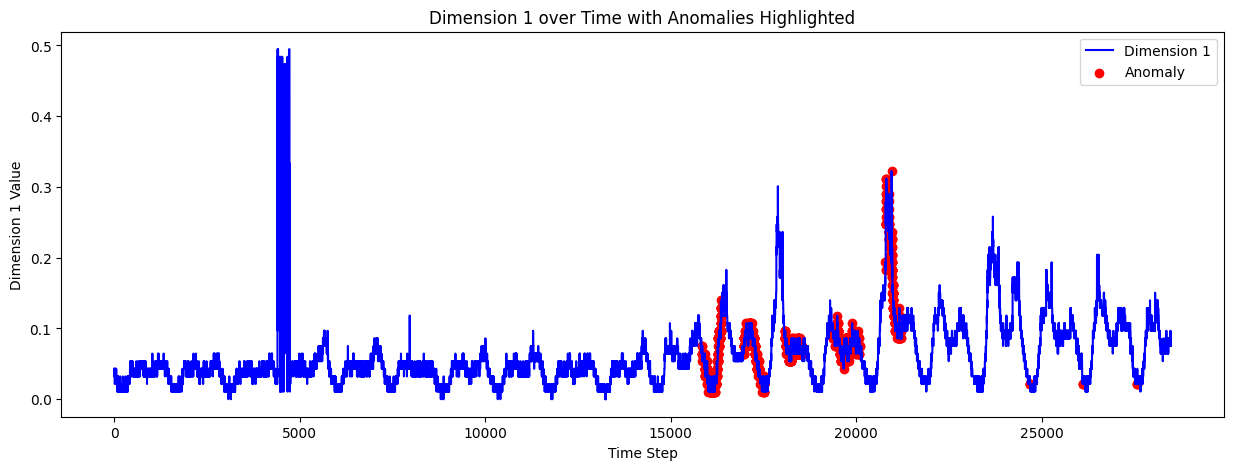

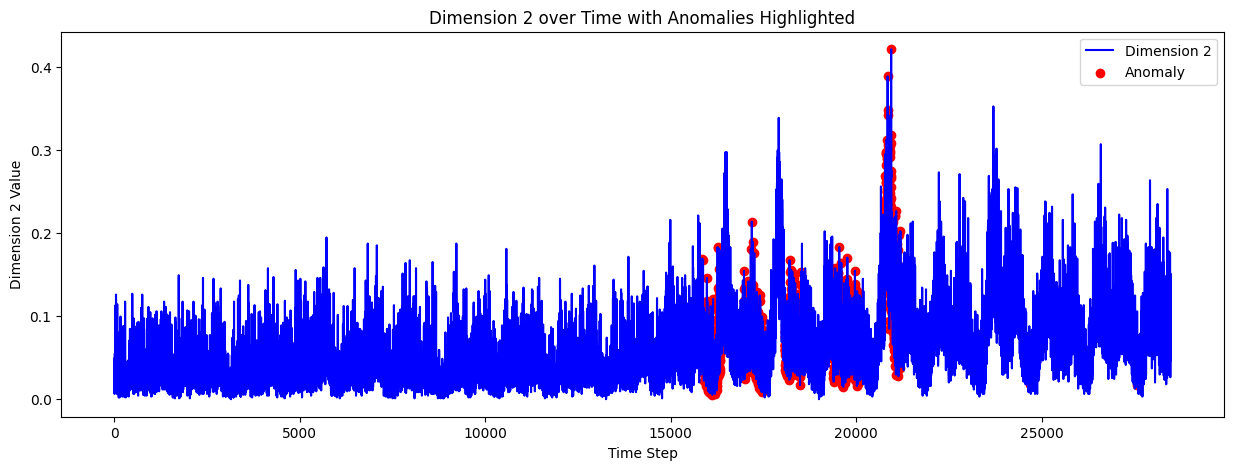

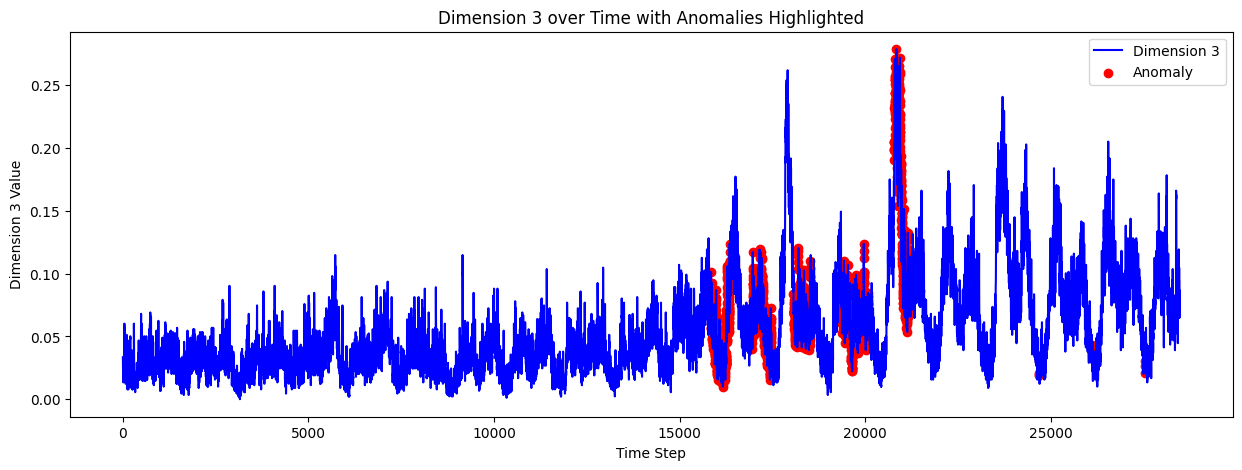

In [7]:
import matplotlib.pyplot as plt

# Function to plot a given dimension with anomalies highlighted
def plot_dimension_with_anomalies(dimension_number):
    plt.figure(figsize=(15, 5))
    plt.plot(df[f"Dimension {dimension_number}"], label=f"Dimension {dimension_number}", color='blue')
    
    # Highlighting anomalies
    anomalies = df[df['Anomaly'] == 1]
    plt.scatter(anomalies.index, anomalies[f"Dimension {dimension_number}"], color='red', label='Anomaly')
    
    plt.title(f"Dimension {dimension_number} over Time with Anomalies Highlighted")
    plt.xlabel("Time Step")
    plt.ylabel(f"Dimension {dimension_number} Value")
    plt.legend()
    plt.show()

# Plotting the first three dimensions as an example
for i in range(1, 4):
    plot_dimension_with_anomalies(i)

In [8]:
len(df)

28478

In [9]:
past_history = 24
future_target = 6
STEP = 1
predict_col = 0

In [10]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, target_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [11]:

def preprocessing(data, past_history, future_target, STEP, predict_col):

    TRAIN_SPLIT = int(len(data)* 0.8)
    #TRAIN_SPLIT = int(len(data)-len(df2))
    
    #피쳐
    features_considered = ['Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5', 'Dimension 6']
    features = data[features_considered]
    #features.index = data['date']
    #features.plot(subplots=True)
    F_dataset = features.values
    print(np.shape(F_dataset))
    F_scaler.fit(F_dataset)
    F_dataset = F_scaler.transform(F_dataset)
    print(np.shape(F_dataset))
    F_dataset = F_dataset.reshape(-1, len(features_considered))
    print(np.shape(F_dataset))
    print(F_dataset)

    #타겟
    features_considered = ['Dimension 1']
    features = data[features_considered]
    T_dataset = features.values
    T_scaler.fit(T_dataset)
    T_dataset = T_scaler.transform(T_dataset)
    T_dataset = T_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))
    print(T_dataset)

    #이상치
    anomal = ['Anomaly']
    features = data[anomal]
    anomal_dataset = features.values
    
    anomal_dataset = anomal_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))
    print(T_dataset)

    dataset = np.concatenate((T_dataset, F_dataset), axis=1)
    print(dataset)
    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)

    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    x_val_anomal, y_val_anomal = multivariate_data(anomal_dataset, anomal_dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    return x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal


In [12]:
F_scaler = MinMaxScaler()
T_scaler = MinMaxScaler()
x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal = preprocessing(df, past_history, future_target, STEP, predict_col)

(28478, 5)
(28478, 5)
(28478, 5)
[[0.11557838 0.12000057 0.10185314 0.         0.915385  ]
 [0.08291549 0.11599996 0.10185314 0.         0.915385  ]
 [0.06783995 0.10799872 0.09722128 0.         0.912821  ]
 ...
 [0.15577904 0.26400126 0.30555544 0.         0.935897  ]
 [0.13316572 0.24399818 0.29629571 0.         0.933333  ]
 [0.1934679  0.26000065 0.30092757 0.         0.933333  ]]
(28478, 1)
[[0.08695696]
 [0.08695696]
 [0.06521722]
 ...
 [0.17391392]
 [0.17391392]
 [0.15217418]]
(28478, 1)
[[0.08695696]
 [0.08695696]
 [0.06521722]
 ...
 [0.17391392]
 [0.17391392]
 [0.15217418]]
[[0.08695696 0.11557838 0.12000057 0.10185314 0.         0.915385  ]
 [0.08695696 0.08291549 0.11599996 0.10185314 0.         0.915385  ]
 [0.06521722 0.06783995 0.10799872 0.09722128 0.         0.912821  ]
 ...
 [0.17391392 0.15577904 0.26400126 0.30555544 0.         0.935897  ]
 [0.17391392 0.13316572 0.24399818 0.29629571 0.         0.933333  ]
 [0.15217418 0.1934679  0.26000065 0.30092757 0.         0.93

In [13]:
np.shape(x_train_multi)

(3793, 24, 6)

In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 10
EPOCHS = 10
EVALUATION_INTERVAL = len(x_train_multi)//BATCH_SIZE
VALIDATION_STEPS = len(x_val_multi)//BATCH_SIZE # if you have validation data 

In [15]:
def create_time_steps(length):
  return range(-length, 0)

In [16]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  
  plt.plot(num_in, np.array(history[:, predict_col]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'g',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [17]:
from torch import nn, optim
import torch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [18]:
epochs = 50

validation = 0.1

In [19]:
x_val_multi.shape

(945, 24, 6)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='mse', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\
DATA_OUT_PATH = '/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUT'
model_name = 'two_lstm'
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='mse', verbose=1, save_best_only=True, save_weights_only=True)

/Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm -- Folder already exists 



In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Attention
from keras.layers import concatenate

In [22]:
adam = optimizers.Adam(lr = 0.001)

In [23]:
from keras.models import Model
from keras.layers import Input, Conv1D, concatenate, Dense, Flatten

# Define input layer
input_data = Input(shape=x_train_multi.shape[-2:])

# Apply Conv1D to flatten the input

# Flatten the Conv1D output
flattened_output = Flatten()(input_data)

# Define dense layers
dense1 = Dense(64, activation='relu')(flattened_output)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(6)(dense2)



Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-18 14:36:12.006667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 14:36:12.006763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
model = Model(inputs = input_data, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 6)]           0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 64)                9280      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 11,558
Trainable params: 11,558
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model_history=model.fit(x_train_multi, y_train_multi, epochs=20,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          #validation_data=val_data_multi,
                                          validation_steps=VALIDATION_STEPS, 
                                          batch_size = BATCH_SIZE, callbacks=[earlystop_callback, cp_callback], validation_data=(x_val_multi, y_val_multi))


Epoch 1/20


2024-04-18 14:36:12.180564: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-18 14:36:12.326904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


110/118 [==========================>...] - ETA: 0s - loss: 0.0166 - mse: 0.0166
Epoch 1: mse improved from inf to 0.01557, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 1s 6ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 2/20


2024-04-18 14:36:13.513464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


110/118 [==========================>...] - ETA: 0s - loss: 0.0023 - mse: 0.0023
Epoch 2: mse improved from 0.01557 to 0.00215, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 1s 6ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 3/20
111/118 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 3: mse improved from 0.00215 to 0.00182, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 6.5273e-04 - val_mse: 6.5273e-04
Epoch 4/20
113/118 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 4: mse improved from 0.00182 to 0.00163, saving model to /Users/hyeyoung/Capstone/OmniAnomaly/ServerMachineDataset/OUTtwo_lstm/weights.h5
118/118 [==============================] - 1s 6ms/step -

In [26]:
mse = model.evaluate(x_val_multi, y_val_multi, batch_size = 1)

945/945 [==============================] - 3s 3ms/step - loss: 4.9067e-04 - mse: 4.9067e-04


In [27]:
y_predict = model.predict(x_val_multi[0:1000])
#for i in tqdm(range(len(y_predict))):
#    print(y_val_multi[i], y_predict[i])

30/30 [==============================] - 0s 2ms/step


2024-04-18 14:36:21.378282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [28]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
from sklearn.metrics import r2_score
def RMSE(real, pred):
    return np.sqrt((1/len(real))* np.sum((real-pred)**2))

In [29]:
answer_list = []
predict_list = []
anomal_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, 24, 6))
    answer = y_val_multi[i]
    anomal = y_val_anomal[i]
    predict = model.predict(x)[0]
    answer_list.append(answer)
    anomal_list.append(anomal)
    predict_list.append(predict)

1/1 [==============================] - 0s 8ms/step


In [30]:
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1)) 
anomal = np.reshape(anomal_list, (-1, 1)) 



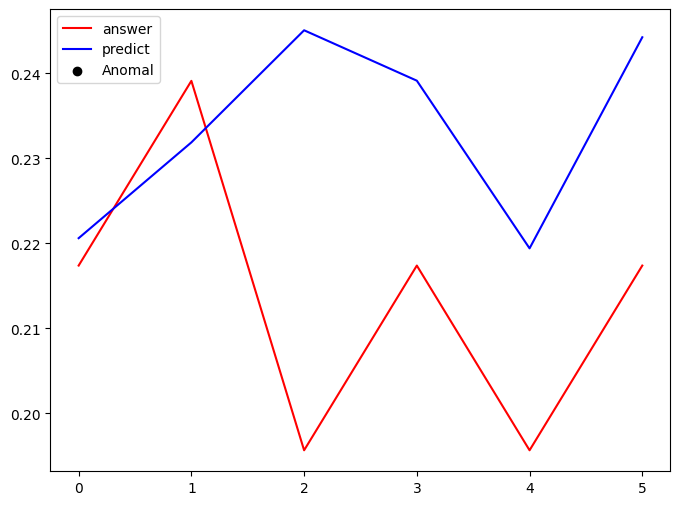

In [31]:
t = 4
plt.plot(answer_list[t], color = 'r', label = 'answer')
plt.plot(predict_list[t], color = 'b', label = 'predict')
anomal_event = anomal_list[t]
indices_with_value_one = [index for index, value in enumerate(anomal_event) if np.any(value == 1)]
plt.scatter(indices_with_value_one, [predict_list[t][i] for i in indices_with_value_one], color='k', label='Anomal', marker='o')

plt.legend()
plt.show()

In [32]:
import numpy as np



# 값이 1인 인덱스 저장
indices_with_value_one = [index for index, value in enumerate(anomal) if np.any(value == 1)]

# 결과 출력
print("값이 1인 인덱스:", indices_with_value_one)


값이 1인 인덱스: [1872, 1873, 1874, 1875, 3307, 3308, 3309, 4747, 4748, 4749]


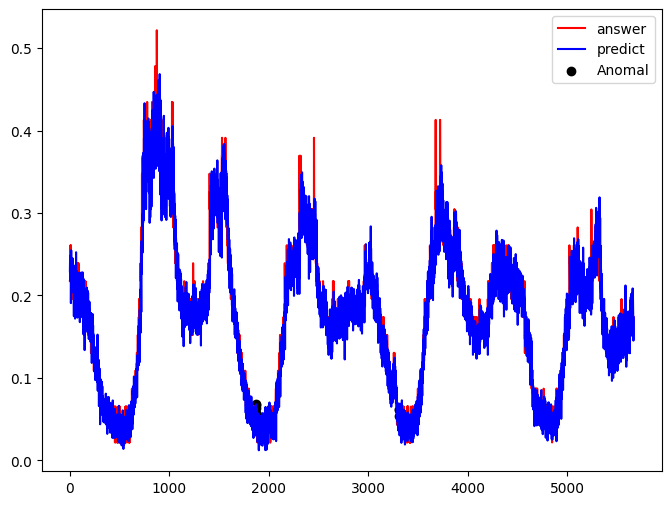

In [33]:
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')
plt.scatter(indices_with_value_one, [predict[i] for i in indices_with_value_one], color='k', label='Anomal', marker='o')  # 이상치 산점도

plt.legend()
plt.show()

In [34]:
anomal_predict = [predict[i] for i, value in enumerate(anomal) if value == 1]
anomal_answer = [answer[i] for i, value in enumerate(anomal) if value == 1]

print(anomal_predict)
print(anomal_answer)

[array([0.06728938], dtype=float32), array([0.06797212], dtype=float32), array([0.05802661], dtype=float32), array([0.06358138], dtype=float32), array([0.05401409], dtype=float32), array([0.06121691], dtype=float32), array([0.06234202], dtype=float32), array([0.06617146], dtype=float32), array([0.0526446], dtype=float32), array([0.05526477], dtype=float32)]
[array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747]), array([0.04347747])]


In [35]:
a = anomal_answer
b = anomal_predict
from sklearn.metrics import mean_absolute_percentage_error

print(mse(a, b).numpy()) 



# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(anomal_predict, anomal_answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100

print("평균 백분율:", mean_percentage_diff)


0.00033024134
평균 백분율: 9.68894499739797


In [36]:

a = answer
b = predict
from sklearn.metrics import mean_absolute_percentage_error
#print(mae(a, b).numpy())
print(mse(a, b).numpy()) 
#print(r2_score(a, b))
#print(RMSE(a, b))
#print(mean_absolute_percentage_error(answer, predict))
# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(predict, answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100

print("평균 백분율:", mean_percentage_diff)

0.00049067446
평균 백분율: 9.256317972396515
